# Spotify Song Popularity Analysis

This project explores the Kaggle dataset "30000 Spotify Songs" by Joakim Arvidsson. It contains track-level audio features and popularity scores. The goal is to understand **what makes songs popular on Spotify** and whether **popularity can be predicted using only audio features**.

### Questions we want to answer:
1. How are audio features distributed across songs?
2. Do certain audio features show stronger relationships with track popularity?
3. Are there differences in popularity across genres, keys, or musical modes?
4. What characteristics distinguish the top 20% of popular songs from the rest?
5. Can we build a simple model to predict popularity from audio features?

## 0. Set Up
- Import the necessary libraries.
- Reading the CSV and understanding what columns exist.
- Having a quick preview of what the data looks like.

In [296]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

# Read the CSV file into a DataFrame
df = pd.read_csv("spotify_songs.csv")

# List the number of rows and columns the dataset has
print("(Number of rows, Number of columns): ", df.shape, '\n')

# List the existing features
print("Columns:")
print(df.columns)

# Peek at the first 5 rows
df.head()

(Number of rows, Number of columns):  (32833, 23) 

Columns:
Index(['track_id', 'track_name', 'track_artist', 'track_popularity',
       'track_album_id', 'track_album_name', 'track_album_release_date',
       'playlist_name', 'playlist_id', 'playlist_genre', 'playlist_subgenre',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms'],
      dtype='object')


,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


## 1. Basic Cleaning
Removal of duplicates, checks for missing values, and conversion of the album release date into a real date format.
Then, a peek at the changes.

In [298]:
# Drop the duplicate rows
before = len(df)
df = df.drop_duplicates()
after = len(df)
print("Dropped duplicates: ", before - after)

# Check for missing values
missing = df.isna().mean().sort_values(ascending=False)
print(missing.head(10))

# Convert the album release date into a real date format
df["track_album_release_date"] = pd.to_datetime(
    df["track_album_release_date"], errors="coerce"
)

# Extracting just the year 
df["release_year"] = df["track_album_release_date"].dt.year
df["release_year"] = df["release_year"].astype("Int64") # to convert to int (removes the .0; e.g. 2019.0 -> 2019)

# Peek at what has changed
df[["track_album_release_date", "release_year"]].head()

Dropped duplicates:  0
track_artist        0.000152
track_album_name    0.000152
track_name          0.000152
track_id            0.000000
key                 0.000000
tempo               0.000000
valence             0.000000
liveness            0.000000
instrumentalness    0.000000
acousticness        0.000000
dtype: float64


,track_album_release_date,release_year
0,2019-06-14,2019
1,2019-12-13,2019
2,2019-07-05,2019
3,2019-07-19,2019
4,2019-03-05,2019


## 2. Descriptive Statistics
Ensuring the dataset is proper and makes sense.

In [300]:
# List of important numeric columns we want to observe
numeric = [
    "track_popularity", "danceability", "energy", "loudness", "speechiness", 
    "acousticness", "instrumentalness", "liveness", "valence", "tempo", 
    "duration_ms", "key", "mode"
]

# Describe the features
# List the count, mean, std, min, quartiles, and max
df[numeric].describe().T

,count,mean,std,min,25%,50%,75%,max
track_popularity,32833.0,42.477081,24.984074,0.000000,24.0000,45.000000,62.00000,100.000
danceability,32833.0,0.654850,0.145085,0.000000,0.5630,0.672000,0.76100,0.983
energy,32833.0,0.698619,0.180910,0.000175,0.5810,0.721000,0.84000,1.000
loudness,32833.0,-6.719499,2.988436,-46.448000,-8.1710,-6.166000,-4.64500,1.275
speechiness,32833.0,0.107068,0.101314,0.000000,0.0410,0.062500,0.13200,0.918
acousticness,32833.0,0.175334,0.219633,0.000000,0.0151,0.080400,0.25500,0.994
instrumentalness,32833.0,0.084747,0.224230,0.000000,0.0000,0.000016,0.00483,0.994
liveness,32833.0,0.190176,0.154317,0.000000,0.0927,0.127000,0.24800,0.996
valence,32833.0,0.510561,0.233146,0.000000,0.3310,0.512000,0.69300,0.991
tempo,32833.0,120.881132,26.903624,0.000000,99.9600,121.984000,133.91800,239.440


## 3. Histograms - Distributions
Using histograms to visualize how the values are spread.

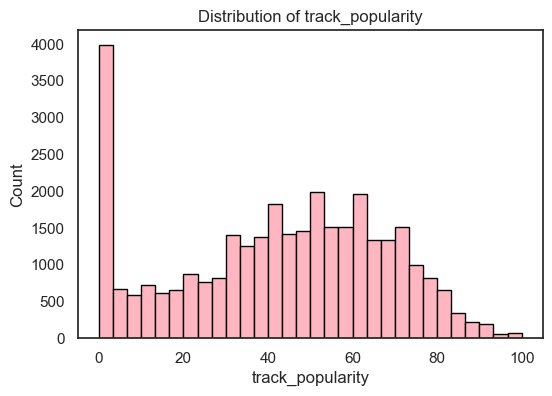

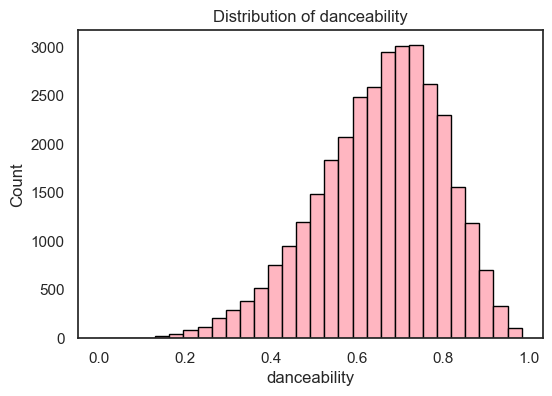

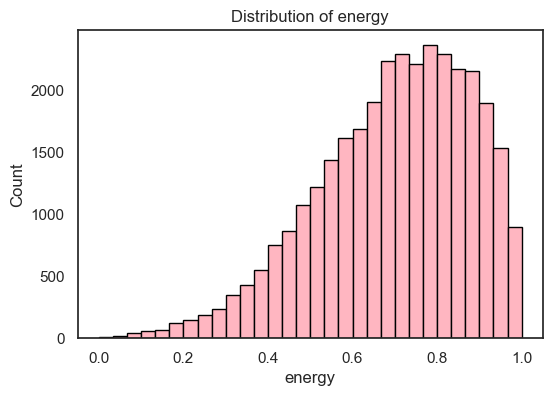

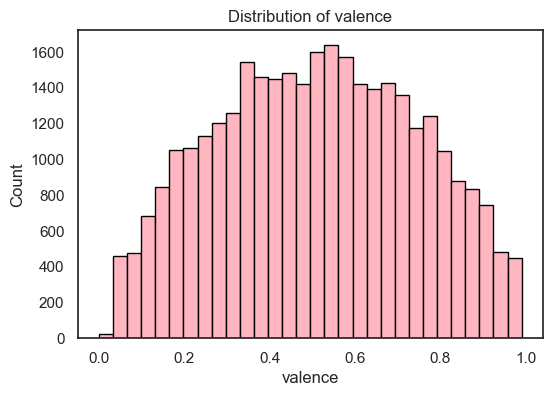

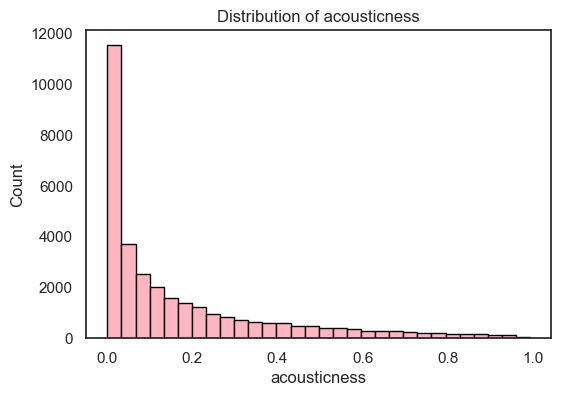

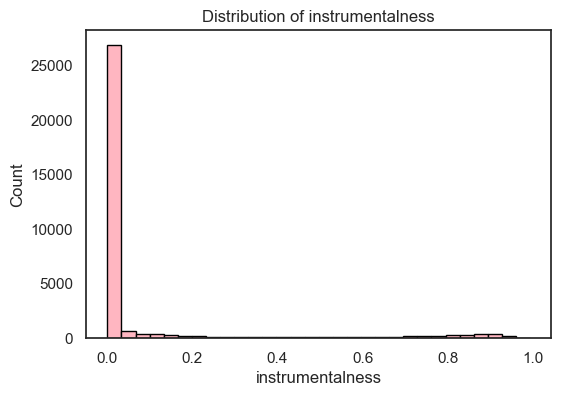

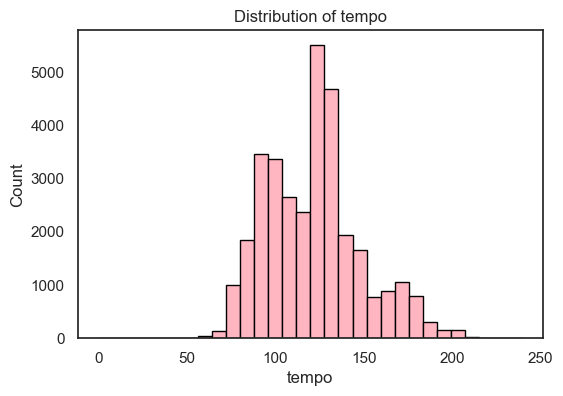

In [302]:
# Columns to visualize
cols = ["track_popularity", "danceability", "energy", "valence", "acousticness", 
        "instrumentalness", "tempo"]

for col in cols:
    plt.figure(figsize=(6,4))
    plt.hist(df[col].dropna(), bins=30, color="lightpink", edgecolor="black")
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

**Question 1: How are audio features distributed across songs?**

The histograms shows that the track popularity feature is heavily skewed towards  low values, with many songs near 0 popularity. Majority of danceability was shown to be between 0.6-0.8, energy around 0.7-0.9, and tempo centered near 120 BPM. Instrumentalness and acousticness are also heavily skewed towards 0, indicating that most tracks are vocal and not acoustic.

## 4. Scatter Plots - Relationships with Popularity
Do certain audio features seem to go up or down with popularity?

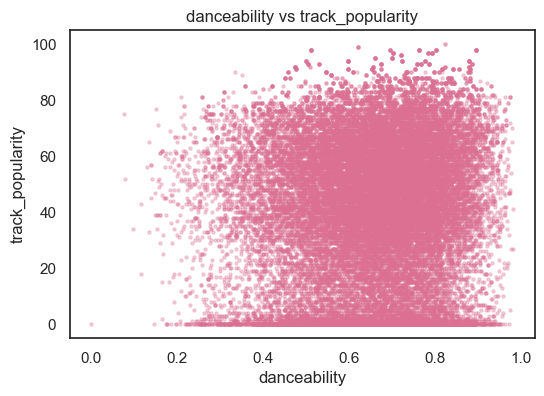

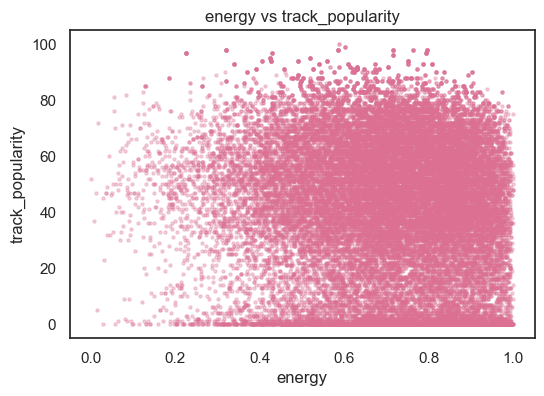

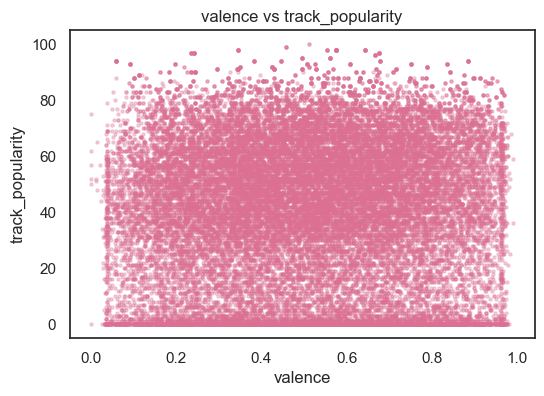

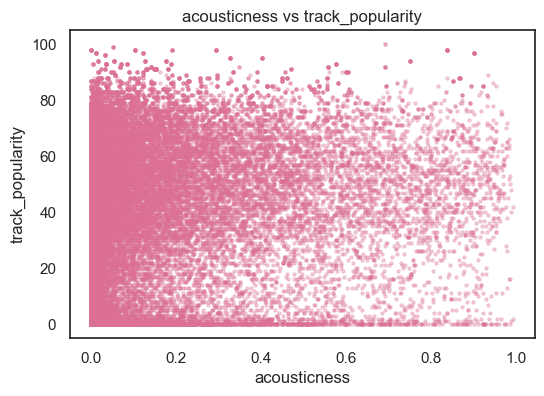

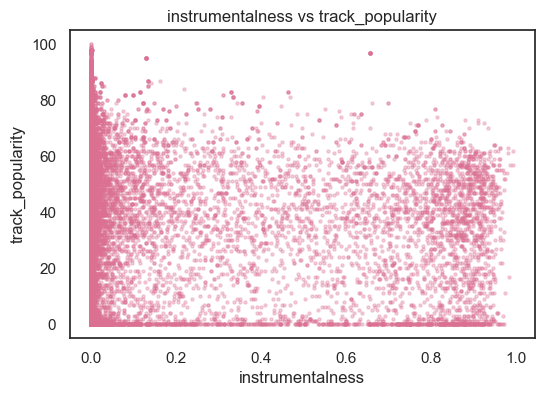

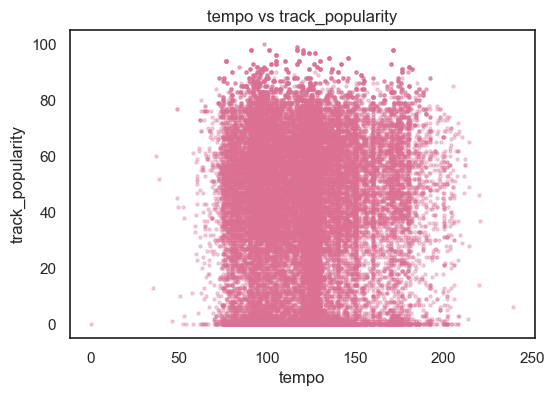

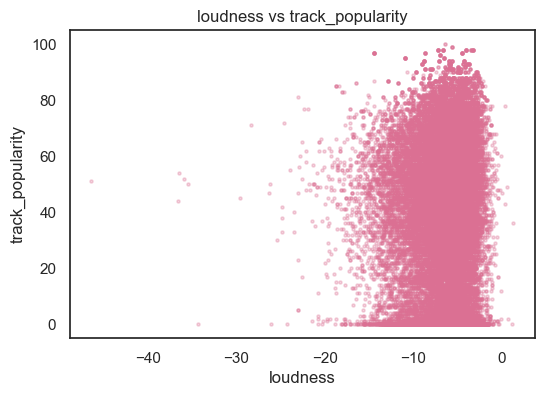

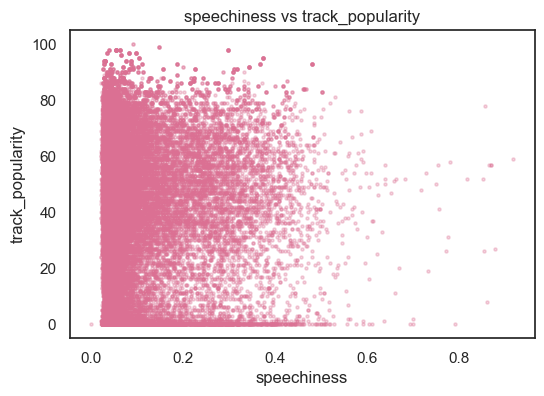

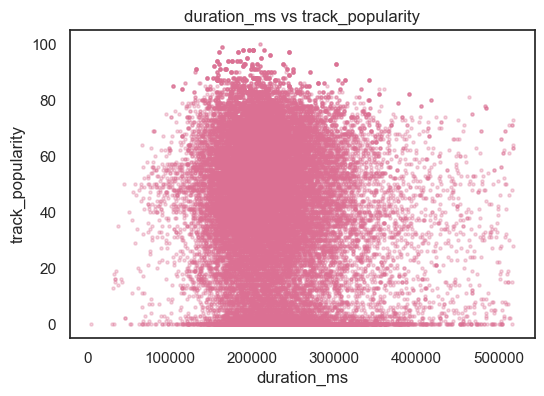

In [304]:
# Features that we want to compare against popularity
features = ["danceability", "energy", "valence", "acousticness", "instrumentalness",
            "tempo", "loudness", "speechiness", "duration_ms"]

for col in features:
    plt.figure(figsize=(6,4))
    plt.scatter(df[col], df["track_popularity"], s=5, alpha=0.3, color="palevioletred")
    plt.title(f"{col} vs track_popularity")
    plt.xlabel(col)
    plt.ylabel("track_popularity")
    plt.show()

## 5. Numbers - Correlation Coefficient
Quantifying the observations from the scatter plots.
***
- Range: -1 to +1
- Close to +1: strong positive relationship
- Close to -1: strong negative relationship
- Around 0: no relationship (random cloud)

In [307]:
# Compute correlation matrix
corr = df[features + ["track_popularity"]].corr()

# Show sorted correlations with popularity
corr["track_popularity"]. sort_values(ascending=False)

track_popularity    1.000000
acousticness        0.085159
danceability        0.064748
loudness            0.057687
valence             0.033231
speechiness         0.006819
tempo              -0.005378
energy             -0.109112
duration_ms        -0.143682
instrumentalness   -0.149872
Name: track_popularity, dtype: float64

## 6. Heatmap
From purely eyeballing the scatter plots and comparing it to the correlation coefficients, the acousticness and energy correlation coefficients may feel mismatched.
To further investigate, I will plot a **heatmap** as well as **popularity boxplot** into "low/mid/high" and compare the averages.

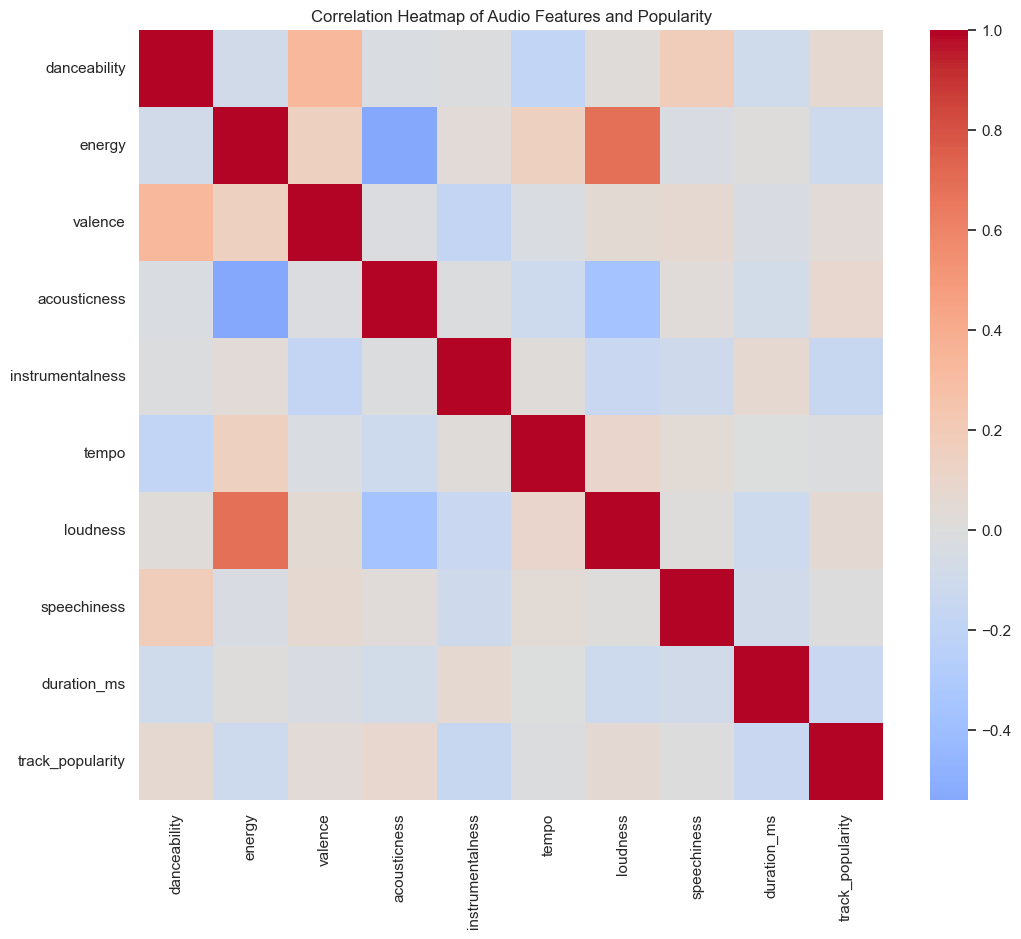

In [310]:
corr = df[features + ["track_popularity"]].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=False, fmt=".2f", cmap="coolwarm", center=0, mask=None)
plt.title("Correlation Heatmap of Audio Features and Popularity")
plt.show()

**Question 2: Do certain audio features show stronger relationships with track popularity?**

The scatter plots showed noisy clouds with no presence of strong linear relationships. The correlation heatmap confirmed this with its row of near-white colours.

## 7. Boxplot

C:\Users\dorot\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


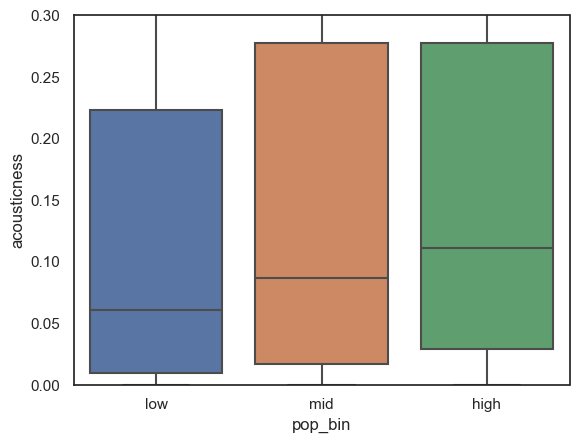

In [314]:
df["pop_bin"] = pd.cut(df["track_popularity"], bins=[0,33,66,100], labels=["low","mid","high"])
sns.boxplot(x="pop_bin", y="acousticness", data=df)

# Adjusting the y-axis to be clearer
plt.ylim(0, 0.3)
plt.show()

**Key Insight I - Acousticness vs Popularity**

As observed from the heatmap, the light reddish colour indicates a slight positive relation.

Additionally, what we can gather from the boxplot, the median acousticness are:
*  Low popularity (blue):  0.05
*  Mid popularity (orange): 0.08-0.1
*  High popularity (green): 0.1-0.12

From the above, we can see that the medians gets a little high as popularity increases. However, all three groups overalp a lot. This confirms that:
1. On average, popular songs are slightly more acoustic than unpopular songs in this dataset.
   *  This explains why the correlation coefficient for acousticness was positive (+0.08)
2. But the effect is minute as the distributions overlap so much
   *  This means acousticness alone cant predict popularity

***

**Takeaway:**
> The boxplots showed that high-popularity songs had slightly higher acousticness than low-popularity songs. This explains the small positive correlation (+0.08) found earlier. However, the distributions overlap heavily, suggesting that acousticness has only a weak influence on popularity.ight Ic (median ~0.1 vs ~0.05 for low-popularity songs).  
This explains the sma sitive correlation (+0.08).  
However, distributions overlap heavily, meaning acousticness alone is a weak predictor of popularity.

C:\Users\dorot\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


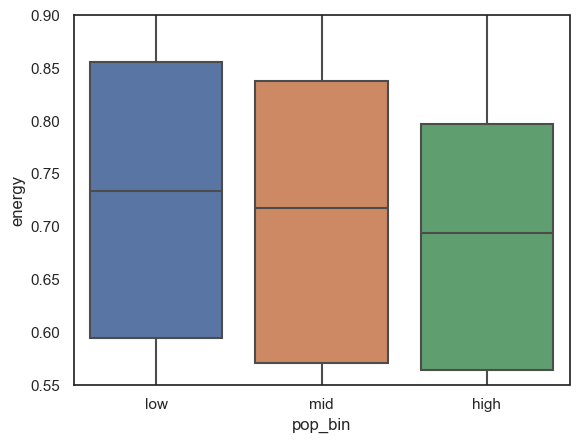

In [317]:
df["pop_bin"] = pd.cut(df["track_popularity"], bins=[0,33,66,100], labels=["low","mid","high"])
sns.boxplot(x="pop_bin", y="energy", data=df)

# Adjusting the y-axis to be clearer
plt.ylim(0.55, 0.9)
plt.show()

**Key Insight II - Energy vs Popularity**

As observed from the heatmap, the light blueish  colour indicates a slight negative relation.

What we can gather from the boxplot, the median energies are:
*  Low popularity (blue):  0.73-0.75
*  Mid popularity (orange): 0.71-0.73
*  High popularity (green): 0.7

From the above, we can see that the medians are very close, meaning there is not a significant difference in energy across the popularity bins. This confirms that:
1. There isn't a strong linear relationship.
2. Popular songs do not favor higher or lower energy but just exist across the whole spectrum.

***

**Takeaway:**
> Although the scatter plots suggested a possible trend between energy and popularity, both correlation coefficients (-0.11) and grouped boxplots showed no strong pattern. Songs across all popularity levels displayed a wide spread of energy, which suggests that energy is not a strong predictor of track popularity.

## 8. Bar Chart - Category Comparisons 
Comparing the categorical features in the dataset: Genres, Keys & Mode.

playlist_genre
pop      47.744870
latin    47.026576
rap      43.215454
rock     41.728338
r&b      41.223532
edm      34.833526
Name: track_popularity, dtype: float64


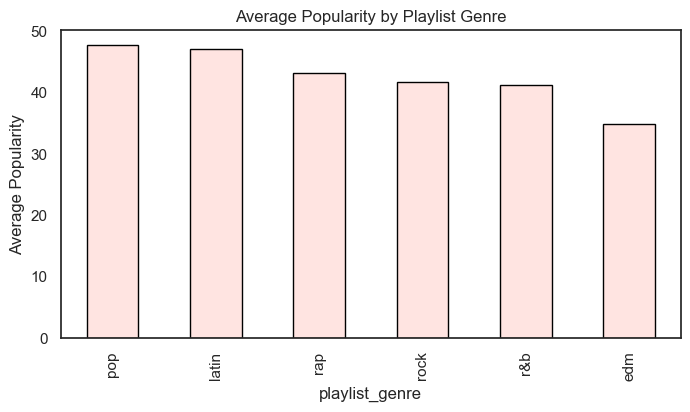

In [321]:
# Average popularity by playlist genre
genre_pop = df.groupby("playlist_genre")["track_popularity"].mean().sort_values(ascending=False)
print(genre_pop)

# Plot it
genre_pop.plot(kind="bar", color="mistyrose", edgecolor="black", figsize=(8,4))
plt.ylabel("Average Popularity")
plt.title("Average Popularity by Playlist Genre")
plt.show()

**Question 3a: Are there differences in popularity across genres?**

Yes. Although the baar charts shows a relatively evenly spread average popularity, it is still observable that the average popularity was highest for Pop and Latin playlists while EDM had the lowest.

key_name
G#/Ab    44.577366
C        43.087145
C#/Db    42.994015
A#/Bb    42.957765
F#/Gb    42.581648
F        42.498507
B        42.409212
A        42.234225
E        42.028169
D        41.581535
D#/Eb    41.399781
G        40.904535
Name: track_popularity, dtype: float64


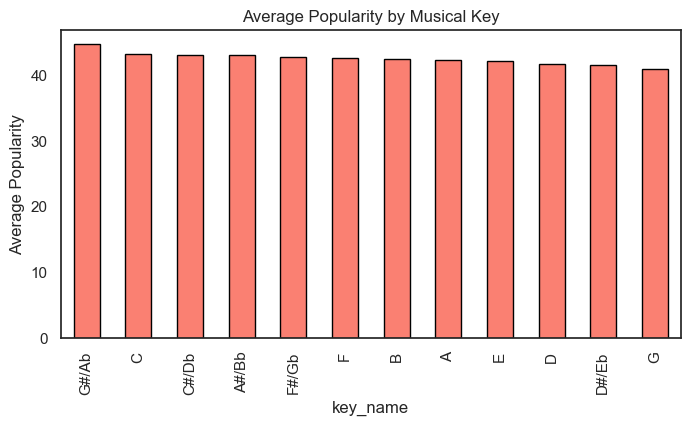

In [324]:
# Mapping Spotify keys (0-11) to note names
key_map = {
    0:"C", 1:"C#/Db", 2:"D", 3:"D#/Eb", 4:"E", 5:"F", 6:"F#/Gb", 7:"G",
    8:"G#/Ab", 9:"A", 10:"A#/Bb", 11:"B"
}
df["key_name"] = df["key"].map(key_map)

# Average popularity by key
key_pop = df.groupby("key_name")["track_popularity"].mean().sort_values(ascending=False)
print(key_pop)

# Plot it
key_pop.plot(kind="bar", color="salmon", edgecolor="black", figsize=(8,4))
plt.ylabel("Average Popularity")
plt.title("Average Popularity by Musical Key")
plt.show()

**Question 3b: Are there differences in popularity across keys?**

There is only a minute difference observed in the bar charts for the different keys, with G#/Ab slightly higher. This suggests that musical key is not a strong factor in predicting popularity.

mode_name
Major    42.709917
Minor    42.173785
Name: track_popularity, dtype: float64


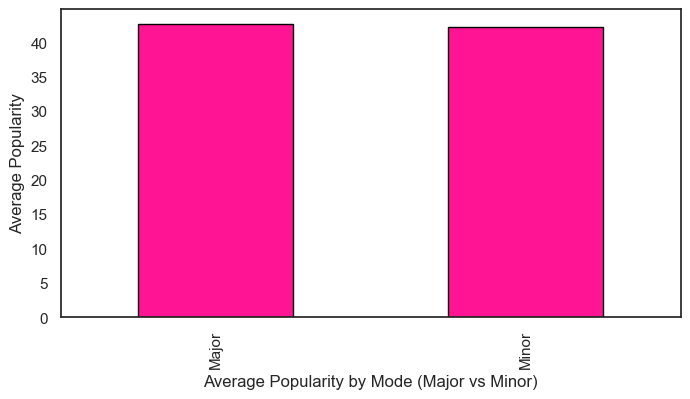

In [327]:
# Spotify encodes: 
# mode = 1 (Major key) and mode = 0 (Minor key)

# Average popularity by mode 
mode_map = {0: "Minor", 1: "Major"}
df["mode_name"] = df["mode"].map(mode_map)

mode_pop = df.groupby("mode_name")["track_popularity"].mean()
print(mode_pop)

# Plot it
mode_pop.plot(kind="bar", color="deeppink", edgecolor="black", figsize=(8,4))
plt.ylabel("Average Popularity")
plt.xlabel("Average Popularity by Mode (Major vs Minor)")
plt.show()

**Question 3c: Are there differences in popularity across modes?**

Songs in major keys averaged a few points more popular than minor key songs, though the effect was small.

## 9. Top 20% vs the Rest
Now the dataset will be split into:
*  Top 20% of popular songs
*  The rest (bottom 80%)

Mean Difference (Top 20% - the Rest): 
loudness               0.650776
valence                0.026161
acousticness           0.020154
danceability           0.019589
speechiness           -0.001046
energy                -0.028428
instrumentalness      -0.083945
tempo                 -0.390864
duration_ms        -8683.978174
dtype: float64


Relative Difference (%): 
instrumentalness   -99.053040
loudness            -9.684885
energy              -4.069170
duration_ms         -3.845875
speechiness         -0.976572
tempo               -0.323346
danceability         2.991309
valence              5.123894
acousticness        11.494907
dtype: float64


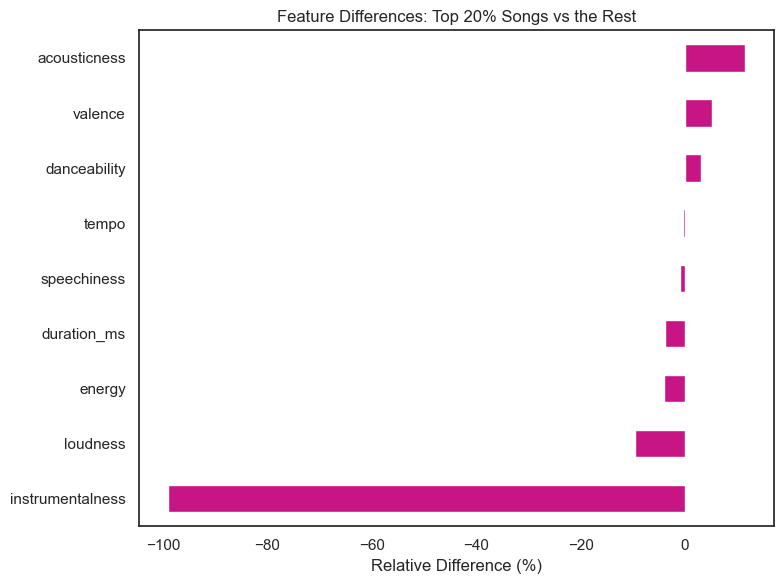

In [331]:
# Define top 20% cutoff
threshold = df["track_popularity"].quantile(0.80)

# Create a new column
# 1 = top 20%, 0 = the rest
df["is_top"] = (df["track_popularity"] >= threshold).astype(int)

# Compare averages of features
means = df.groupby("is_top")[features].mean().T
diff = means[1] - means[0] # mean(top 20%) - mean(rest)

print("Mean Difference (Top 20% - the Rest): ")
print(diff.sort_values(ascending=False))
print('\n')

# Calculate the percentage relative to overall mean of each feature
# Raw difference / mean * 100
feature_means = df[features].mean()
rel_diff = (diff / feature_means) * 100

print("Relative Difference (%): ")
print(rel_diff.sort_values())

# Plot differences
rel_diff.sort_values().plot(kind="barh", color="mediumvioletred", figsize=(8,6))
plt.xlabel("Relative Difference (%)")
plt.title("Feature Differences: Top 20% Songs vs the Rest")
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
<b>Note:</b> The relative difference for loudness looks misleading! In the relative scale, loudness came out negative because the overall mean is negative (loudness is measured in dB, usually -6dB to -10dB). The actual raw difference shows that the top songs are louder, so stick to raw differences for loudness.
</div>


**Question 4: What characteristics distinguish the top 20% of popular songs from the rest?**

Compared to the rest of the dataset, the top 20% of popular songs were nearly 100% less instrumental, slightly shorter in duration (~9s shorter), and on average louder. A slight increase in acousticness (+11%), valence (+5%), and danceability (+3%) was also shown. These patterns suggest that popular tracks are less likely to be instrumental, somewhat happier and more danceable, and a bit louder than less popular ones.

## 10. Baseline Model (Linear Regression)
Using a linear regression model to predict popularity of songs.

In [336]:
# Pick features (X) and target (y)
X = df[["danceability", "energy", "valence", "acousticness", "instrumentalness",
        "tempo", "loudness", "speechiness", "duration_ms"]]
y = df["track_popularity"]

# Split dataset into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate
print("R^2 score: ", r2_score(y_test, y_pred))
print("Mean Absolute Error: ", mean_absolute_error(y_test, y_pred))

# Look at feature coefficients
coefs = pd.Series(model.coef_, index=X.columns).sort_values(ascending=False)
print(coefs)

R^2 score:  0.07025685220976585
Mean Absolute Error:  20.089076103130477
danceability         5.594672
acousticness         3.556825
valence              2.641146
loudness             1.522983
tempo                0.021630
duration_ms         -0.000046
speechiness         -8.223101
instrumentalness   -12.016502
energy             -30.003000
dtype: float64


**Question 5: Can we build a simple model to predict popularity?**

The low R^2 score of 0.07 means that the model explains only ~7% of the variation in popularity. This suggests that audio features alone are not enough to predict popularity well.

The big MAE score indicates that the model's predictions are off by 20 points on average, which is expected as popularity is noisy and hard to predict.

***

**Other features of the model:**

The coefficients show which features the model thinks matter most (positive = more popular, negative = less popular). Danceability, acousticness, valence, and loudness has been highlighted.

***

**Takeaway:**

> The model confirms the analysis that has been done so far:
>*  Popular songs are dancable, acoustic, happy, and loud.
>*  They are rarely instrumental or speechy.

>But since R^2 is low, we conclude:
>*  Popularity cannot be well predicted by audio features alone.

# 11. Findings & Conclusion

## Key Findings:
- **Distribution & correlations**
  - Most features cluster within typical ranges, with exceptions: instrumentalness, acousticness, and track popularity skewed to 0.
  - There is weak correlations overall; Audio features individually had weak linear correlations with popularity (|r| <= 0.15).  It was observed that louder, more danceable, acoustic songs were slightly more popular; instrumental and speechy songs were less.
  - Stronger feature-to-feature correlations exist (e.g. energy and loudness = ~0.7).

- **Category comparisons**
  - Pop and Latin playlists are the most popular.
  - Musical key had only minute differences.
  - Major key songs averaged slightly higher popularity than minor ones.

- **Top 20% vs the rest**
  - Top songs are less instrumental, shorter, louder, and modestly more acoustic, danceable, and positive.

- **Modeling**
  - Simple linear regression explained only ~7% of the variation in popularity (R^2 = ~0.07), suggesting that audio features alone can't predict popularity.
  - MAE = ~20 points, meaning predictions are off by ~20 on average.
  - Coefficients aligned with EDA: danceable, acoustic, happy, loud songs are more popular, while instrumental/speechy tracks are less.

### Limitations:
- Audio features alone are not enough to predict popularity — external factors like marketing, playlists, and cultural context dominate.
- Dataset comes from curated Spotify playlists, which may not fully represent the platform’s global catalog.

### Future Projects:
- Try classification (predicting Top 20% vs Rest) instead of regression.
- Explore trends over release years — how features of popular songs evolve over time.
- Incorporate lyrics, playlist placement, or artist metadata to boost prediction accuracy.
- Experiment with tree-based models (Random Forest, XGBoost) to capture non-linear relationships.